In [1]:
import os
import uproot
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import axes3d, Axes3D

#os.environ["KERAS_BACKEND"] = "plaidml.keras.backend"

import keras.backend as K

from keras.models import Sequential
from keras.layers import Dense

from keras.models import Model
from keras.layers import Dense, Input, Dropout, MaxPooling2D, Flatten
from keras import regularizers
from keras.layers.merge import concatenate
import keras.losses

from sklearn.preprocessing import RobustScaler
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle

from scipy.stats import ks_2samp

os.chdir('../src/')
import ml_analysis_plotting

Using TensorFlow backend.
/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/dtypes.py:519: FutureWarn

In [2]:
def  get_input_arrays(tree, features_list):
    array = np.transpose(tree.arrays(features_list, outputtype=tuple))
    print(array.shape)
    print(array[0])
    return array

In [3]:
os.chdir('../data')

In [4]:
f = uproot.open('oneNewKINNW_MC16e.root')
tree = f["features"]
tree.keys()

[b'top_pt',
 b'top_eta',
 b'top_phi',
 b'tbar_pt',
 b'tbar_eta',
 b'tbar_phi',
 b'lep_t_pt',
 b'lep_t_eta',
 b'lep_t_phi',
 b'lep_tbar_pt',
 b'lep_tbar_eta',
 b'lep_tbar_phi',
 b'nu_top_pt',
 b'nu_top_eta',
 b'nu_top_phi',
 b'nu_tbar_pt',
 b'nu_tbar_eta',
 b'nu_tbar_phi',
 b'b_pt',
 b'b_eta',
 b'b_phi',
 b'bbar_pt',
 b'bbar_eta',
 b'bbar_phi',
 b'ttbar_pt',
 b'ttbar_eta',
 b'ttbar_phi',
 b'top_m',
 b'tbar_m',
 b'lep_top_m',
 b'lep_tbar_m',
 b'nu_top_m',
 b'nu_tbar_m',
 b'b1_m',
 b'b2_m',
 b'ttbar_m',
 b'met',
 b'met_x',
 b'met_y',
 b'c_nn',
 b'c_rr',
 b'c_kk',
 b'c_rk',
 b'c_kr',
 b'c_nr',
 b'c_rn',
 b'c_nk',
 b'c_kn',
 b'c_nk_p_kn',
 b'c_nr_p_rn',
 b'c_rk_p_kr',
 b'c_nk_m_kn',
 b'c_nr_m_rn',
 b'c_rk_m_kr',
 b'b_kplus',
 b'b_nplus',
 b'b_rplus',
 b'b_kminus',
 b'b_nminus',
 b'b_rminus',
 b'lep_delta_phi',
 b'lep_delta_eta',
 b'top_delta_phi',
 b'top_delta_eta',
 b'lep_dphi_bypt',
 b'costheta_leps_a_k',
 b'costheta_leps_a_n',
 b'costheta_leps_a_r',
 b'costheta_leps_b_k',
 b'costheta_lep

In [5]:
## truth
features_list = [
b'top_eta',
b'top_phi',
b'top_pt',
b'tbar_eta',
b'tbar_phi',
b'tbar_pt',
b'lep_t_pt',
b'lep_t_eta',
b'lep_t_phi',
b'lep_tbar_pt',
b'lep_tbar_eta',
b'lep_tbar_phi',
b'lep_delta_phi',
b'lep_delta_eta',
b'top_delta_phi',
b'top_delta_eta',
b'met_x',
]

## truth, observable
#features_list = [
# b'b1_pt',
# b'b1_eta',
# b'b1_phi',
# b'b2_pt',
# b'b2_eta',
# b'b2_phi',
# b'lep_t_pt',
# b'lep_t_eta',
# b'lep_t_phi',
# b'lep_tbar_pt',
# b'lep_tbar_eta',
# b'lep_tbar_phi',
# b'met_x',
# b'met_y'
#]


## reconstructed
#features_list = [
#b'reco_top_pt',
#b'reco_top_eta',
#b'reco_top_phi',
#b'reco_t_m',
#b'reco_tbar_pt',
#b'reco_tbar_eta',
#b'reco_tbar_phi',
#b'reco_tbar_m',
#b'reco_lep_1_pt',
#b'reco_lep_1_eta',
#b'reco_lep_1_phi',
#b'reco_lep_1_e',
#b'reco_lep_2_pt',
#b'reco_lep_2_eta',
#b'reco_lep_2_phi',
#b'reco_lep_2_e',
#]

## reconstructed
#features_list = [
#b'top_pt',
#b'tbar_pt',
    # DELTAS
#b'lep_delta_phi',
#b'lep_delta_eta',
#b'top_delta_phi',
#b'top_delta_eta'
#]


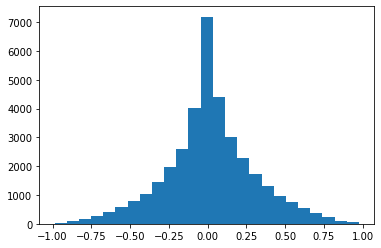

In [6]:
spin_target = tree.array(b'c_kk')#[np.where(spin_target !=  -10.)[0]]
#pt_cut = np.where(spin_target/1000.0 < 300.)[0]
#spin_target = spin_target[pt_cut]
h,b,_=plt.hist(spin_target, bins=25)


In [7]:
NW_weight = tree.array('NW_weight')

(array([ 1955.,   474.,   385.,   363.,   357.,   379.,   433.,   536.,
          908., 30469.]),
 array([1.00723992e-06, 1.00000907e-01, 2.00000806e-01, 3.00000705e-01,
        4.00000604e-01, 5.00000504e-01, 6.00000403e-01, 7.00000302e-01,
        8.00000201e-01, 9.00000101e-01, 1.00000000e+00]),
 <a list of 10 Patch objects>)

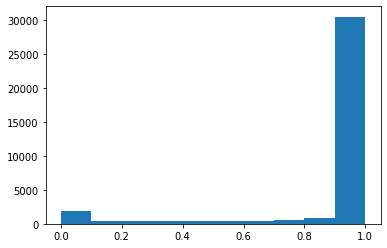

In [8]:
plt.hist(NW_weight)

In [9]:
above5 = np.zeros((len(np.where(NW_weight > 0.5)[0])))
below5 = np.ones((len(np.where(NW_weight < 0.5)[0])))
print(above5.shape)
print(below5.shape)

(32725,)
(3534,)


In [10]:
labels = np.concatenate((above5, below5))

In [11]:
np.where(spin_target ==  -10.)[0]

array([], dtype=int64)

In [12]:
'''
for feature in features_list:
    print(feature)
    #plt.hist(tree1.array(feature),bins=40,density=True,alpha=.8)
    plt.hist(tree.array(feature),bins=40,density=True,alpha=.5)
    plt.show()
'''

'\nfor feature in features_list:\n    print(feature)\n    #plt.hist(tree1.array(feature),bins=40,density=True,alpha=.8)\n    plt.hist(tree.array(feature),bins=40,density=True,alpha=.5)\n    plt.show()\n'

In [13]:
spin_weights = 1/(h * 1/np.max(h))
print(spin_weights)
locs = np.digitize(spin_target, b)
weights_array = np.zeros(len(spin_target))
for i in range(len(spin_weights)):
    weights_array[np.where(locs == i+1)[0]] = spin_weights[i]
#plt.hist(tree.array(feature),bins=40,density=True,alpha=.5)
#plt.show()

[224.78125     84.62352941  43.3313253   27.04135338  17.80445545
  12.31678082   9.18646232   7.05888126   5.00905292   3.66615698
   2.75488319   1.79510856   1.           1.63775046   2.37942441
   3.16454026   4.15060589   5.52457757   7.50835073   9.72027027
  13.0307971   20.09217877  32.54751131  63.65486726 156.36956522]


(array([7193.        , 7193.        , 7193.        , 7193.        ,
        7193.        , 7193.        , 7193.        , 7193.        ,
        7193.        , 7193.        , 7193.        , 7193.        ,
        7193.        , 7193.        , 7193.        , 7193.        ,
        7193.        , 7193.        , 7193.        , 7193.        ,
        7193.        , 7193.        , 7193.        , 7193.        ,
        7036.63043478]),
 array([-0.98753434, -0.90897903, -0.83042373, -0.75186843, -0.67331312,
        -0.59475782, -0.51620251, -0.43764721, -0.35909191, -0.2805366 ,
        -0.2019813 , -0.123426  , -0.04487069,  0.03368461,  0.11223991,
         0.19079522,  0.26935052,  0.34790582,  0.42646113,  0.50501643,
         0.58357173,  0.66212704,  0.74068234,  0.81923765,  0.89779295,
         0.97634825]),
 <a list of 25 Patch objects>)

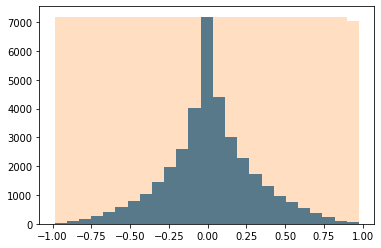

In [14]:
plt.hist(spin_target,bins=25)
plt.hist(spin_target,bins=25,weights=weights_array,alpha=.25)

### This scales the target in order for the ML to be successful

In [15]:
spin_transformer = RobustScaler()
spin_target_scaled = spin_transformer.fit_transform(spin_target.reshape(-1,1))
spin_target_scaled = (spin_target_scaled - np.min(spin_target_scaled))/(np.max(spin_target_scaled) - np.min(spin_target_scaled))
print(spin_target_scaled.shape)

(36259, 1)


In [16]:
features_array = get_input_arrays(tree, features_list)

(36259, 17)
[-2.38100863e+00 -2.62975156e-01  1.76077469e+05 -2.84943867e+00
  2.55803895e+00  2.57955215e+04  4.20560938e+04 -7.84886003e-01
 -2.59616232e+00  8.59698281e+04 -1.89798307e+00 -8.16491306e-01
  1.77967101e+00  1.11309707e+00  2.82101411e+00  4.68430042e-01
  4.25833660e+03]


In [17]:
print(spin_target[:10])
print(weights_array[:10])

[-0.07050317 -0.46195029 -0.15417739  0.75144123 -0.10201702 -0.15093395
  0.00336672 -0.22049226 -0.59510857  0.39694802]
[ 1.79510856  9.18646232  2.75488319 32.54751131  1.79510856  2.75488319
  1.          3.66615698 17.80445545  5.52457757]


In [18]:
np.where(np.isnan(features_array) == True)

(array([], dtype=int64), array([], dtype=int64))

In [19]:
transformer = RobustScaler()
features_array_scaled = transformer.fit_transform(features_array)
print(features_array_scaled.shape)

(36259, 17)


In [20]:
model = Sequential()
model.add(Dense(200, input_dim=len(features_list), activation='relu'))
#model.add(Dropout(0.5))
model.add(Dense(100, activation='relu'))
#model.add(Dropout(0.5))
model.add(Dense(50, activation='relu'))
#model.add(Dropout(0.5))
model.add(Dense(25, activation='relu'))
#model.add(Dropout(0.5))
model.add(Dense(1, activation='sigmoid'))

In [21]:
#model = multihead_model(features_list)

In [22]:
def custom_loss(y_true, y_pred):
    
    return ((K.abs(y_pred) * 1.0) * keras.losses.logcosh(y_pred, y_true))
    #return (keras.losses.logcosh(y_pred, y_true))
def custom_loss_2(y_true, y_pred):
    
    return (y_true - y_pred)
    #return (keras.losses.logcosh(y_pred, y_true))

In [23]:
#model.compile(loss='logcosh', optimizer='adam', metrics=['mae', 'mse'])
#model.compile(loss=[custom_loss], optimizer='adam', metrics=['mae', 'mse',custom_loss_2])
model.compile(loss="binary_crossentropy", optimizer='adam', metrics=["accuracy"])

In [24]:
#features_array_scaled, spin_target_scaled, weights_array = shuffle(features_array_scaled, spin_target_scaled, weights_array)
selection1 = np.random.choice(np.where(labels == 0)[0],len(below5),replace=False)
selection2 = np.where(labels == 1)[0]
selection = np.concatenate((selection1,selection2))
features_array_scaled, labels, weights_array = shuffle(features_array_scaled[selection], labels[selection], weights_array[selection])

In [25]:
#X_train, X_test, y_train, y_test, w_train, w_test = train_test_split(features_array_scaled, spin_target_scaled, weights_array, test_size=0.2)
X_train, X_test, y_train, y_test, w_train, w_test = train_test_split(features_array_scaled, labels, weights_array, test_size=0.2)

In [26]:
print(spin_target_scaled[:10])
print(w_train[:10])

[[0.46694806]
 [0.26762498]
 [0.42434153]
 [0.88547838]
 [0.45090135]
 [0.42599308]
 [0.50456227]
 [0.3905743 ]
 [0.1998214 ]
 [0.70497206]]
[ 1.63775046  5.52457757 12.31678082  3.16454026  9.18646232  2.75488319
  5.52457757  1.          9.72027027  1.        ]


## If you don't redefine/compile/build the model, the weights are 'updated' from the previous training

In [27]:
#history = model.fit(X_train, y_train, epochs=600, batch_size=256, verbose=1, validation_split=.2, sample_weight=w_train)
history = model.fit(X_train, y_train, epochs=150, batch_size=32, verbose=1, validation_split=.2)

Train on 4523 samples, validate on 1131 samples
Epoch 1/150
4523/4523 [==============================] - 0s 100us/step - loss: 0.6947 - accuracy: 0.4992 - val_loss: 0.6936 - val_accuracy: 0.5031
Epoch 2/150
4523/4523 [==============================] - 0s 41us/step - loss: 0.6915 - accuracy: 0.5227 - val_loss: 0.6936 - val_accuracy: 0.5164
Epoch 3/150
4523/4523 [==============================] - 0s 55us/step - loss: 0.6879 - accuracy: 0.5384 - val_loss: 0.6966 - val_accuracy: 0.5004
Epoch 4/150
4523/4523 [==============================] - 0s 48us/step - loss: 0.6871 - accuracy: 0.5417 - val_loss: 0.6943 - val_accuracy: 0.5075
Epoch 5/150
4523/4523 [==============================] - 0s 35us/step - loss: 0.6807 - accuracy: 0.5709 - val_loss: 0.7067 - val_accuracy: 0.4987
Epoch 6/150
4523/4523 [==============================] - 0s 59us/step - loss: 0.6756 - accuracy: 0.5766 - val_loss: 0.7021 - val_accuracy: 0.5049
Epoch 7/150
4523/4523 [==============================] - 0s 45us/step - los

In [28]:
model.save_weights('model_weights.h5')

In [29]:
fig, ax = plt.subplots(figsize=(16, 10))
'''
for i in range(1):
    plt.scatter(range(len(histories[i])), histories[i])
'''
#history_hist = plt.hist(history.history['loss'], bins=50)
#plt.plot(range(len(history.history['loss'])), history.history['loss'], label='training w. deltas')
plt.plot(range(len(history.history['loss'])), history.history['loss'], label='training')
plt.plot(range(len(history.history['val_loss'])), history.history['val_loss'], label='validation')
plt.legend(fontsize=30)
plt.xlabel('Epochs', fontsize=20)
plt.ylabel('Mean absolute error', fontsize=20)
plt.title('Loss', fontsize=25)
plt.savefig('loss_wdeltas')
plt.show()

In [30]:
y_pred = model.predict(X_test)
print(model.evaluate(X_test, y_test))

1414/1414 [==============================] - 0s 11us/step
[8.468512365133455, 0.49575671553611755]


(array([710.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0., 704.]),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
 <a list of 10 Patch objects>)

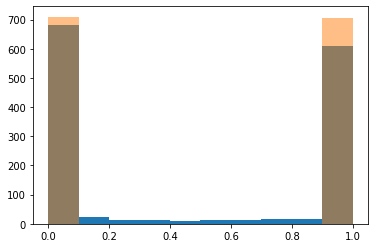

In [37]:
plt.hist(y_pred)
plt.hist(y_test,alpha=.5)

In [32]:
#spin_transformer = RobustScaler()
#spin_target_scaled = spin_transformer.fit_transform(spin_target.reshape(-1,1))
#spin_target_scaled = (spin_target_scaled - np.min(spin_target_scaled))/(np.max(spin_target_scaled) - np.min(spin_target_scaled))
#print(spin_target_scaled.shape)

#transformer = RobustScaler()
#features_array_scaled = transformer.fit_transform(features_array)
#print(features_array_scaled.shape)

In [33]:
y_pred_unscaled = y_pred*2 - 1
y_test_unscaled = y_test*2 - 1

ValueError: all the input arrays must have same number of dimensions

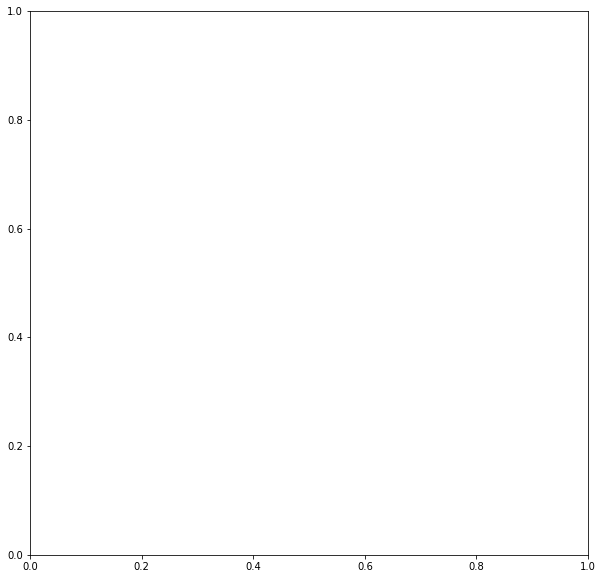

In [34]:
fig, ax = plt.subplots(figsize=(10,10))
a = y_pred_unscaled
b = y_test_unscaled
bins=np.histogram(np.hstack((a,b)), bins=10)[1]
h1,b1,_=plt.hist(a, bins, histtype='step', linewidth=2.5, label='Prediction', color='sandybrown')
h2,b2,_=plt.hist(b, bins, histtype='step', linewidth=2.5, label='truth level', color='steelblue')
plt.legend(fontsize=30)
plt.ylim(0,3000)
plt.xlabel(r'cos$\theta_{k}^{+}$cos$\theta_{k}^{-}$', fontsize=30)
plt.ylabel('Aribitrary Unit', fontsize=30)
#plt.savefig('truth_obs_arb')
plt.show()

In [ ]:
y_diff = y_test_unscaled - y_pred_unscaled
y_diff = y_diff[np.logical_not(np.isnan(y_diff))]
print(np.std((y_test_unscaled - y_pred_unscaled)))

In [ ]:
#print(h)
#tot_h1 = 0.0
#ent = 0.0
#for val in h1: 
#    tot_h1 += val
#for val in h1:
#    probh1 = val/tot_h1
#    if probh1 > 0.0:
#        ent += probh1*np.log(1/probh1)   
    #print(val/tot)
#print("entropy:",ent)
#print(b)
#for i in range(len(h1)):
    #print(h1[i]/tot_h1)
## KL divergence ##
KLdiv = 0.0
for i in range(len(h1)):
    #print("bin", i, h2[i]/tot_h)
    truth_prob = h2[i]/np.sum(h2)
    #print(val/len(a), ent)
    pred_prob = h1[i]/np.sum(h1)
    #pred_prob = 0.0
    if pred_prob == 0.0:
        pred_prob = 0.000001
    if truth_prob == 0.0:
        truth_prob = 0.000001
    KLdiv += truth_prob*(np.log(truth_prob) - np.log(pred_prob))
        #print(KLdiv)
        #KLdiv += (np.log(truth_prob) - np.log(pred_prob))
print(KLdiv)
#plt.annotate("test", (1,0.4))

fig, ax = plt.subplots(figsize=(20,10))
#plt.bar(range(len(h1)),h1/len(a),alpha=.4, color='sandybrown', label='Prediction from truth w deltas')
plt.bar(range(len(h1)),h1/len(a),alpha=.4, color='sandybrown', label='Prediction')
plt.bar(range(len(h2)),h2/len(b),alpha=.5, color='steelblue', label='truth level')
plt.legend(fontsize=30)
plt.xlabel(r'(bins of) cos$\theta_{k}^{+}$cos$\theta_{k}^{-}$', fontsize=30)
plt.ylabel('Probability', fontsize=30)

#plt.annotate("Kullback-Leibler divergence:", (.3,.94))
#plt.annotate("Kullback-Leibler divergence:", (.3,.94), fontsize=24)
#fig = plt.figure()
#text='''testt'''
#fig.text(.1,.1,text)
plt.text(0.14, 0.75,'KL div. = ', ha='right', va='center', transform=ax.transAxes, fontsize=24)
plt.text(0.15, 0.75,round(KLdiv,5), ha='left', va='center', transform=ax.transAxes, fontsize=24)

#plt.text(0.2, 0.8,'epochs = ', ha='right', va='center', transform=ax.transAxes, fontsize=24)
#plt.text(0.211, 0.8,'600', ha='left', va='center', transform=ax.transAxes, fontsize=24)

plt.savefig('probKL_wdeltas')
plt.show()
#print(h1/len(a))

## KL divergence ##
#KLdiv = 0.0
#for i in range(len(h1)):
#    truth_prob = h[i]/tot_h
#    #print(val/len(a), ent)
#    pred_prob = h1[i]/len(a)
#    if pred_prob > 0.0 and truth_prob > 0.0:
#        KLdiv += truth_prob*(np.log(truth_prob) - np.log(pred_prob))
#print(KLdiv)



In [ ]:
class make_hist_dicts:

    def correct_compare_hist(self,
        array1, array2, nBins=40, normed=False, gauss=False, logY=False
    ):
        array1_dict = {"hist":None, "binx":None, "weights":None, "binDx":None}
        array2_dict = {"hist":None, "binx":None, "weights":None, "binDx":None}

        array1 = self.removeNan(array1)
        array2 = self.removeNan(array2)

        if gauss is True:
            ratio = guassian_comparison_ratio(array1, array2, nBins)
        else:
            ratio = np.ones(nBins)
        
        hist1, bins1, hist2, bins2 = self.get_hists(array2, array1, nBins)
        
        stat = np.round(ks_2samp(plt.hist(array1, bins=nBins)[0], plt.hist(array2, bins=nBins)[0]), 4)
        plt.close()
        b1 = np.zeros(len(hist1))
        w1 = np.zeros(len(hist1))
        for i in range(len(hist1)):
            b1[i] = (bins1[i + 1] + bins1[i]) / 2
            w1[i] = bins1[i + 1] - bins1[i]
        b2 = b1
        w2 = w1
        
        array1_dict["binDx"] = w1
        array2_dict["binDx"] = w2
        
        array1_dict["hist"] = hist1
        array2_dict["hist"] = hist2
        
        array1_dict["binx"] = b1
        array2_dict["binx"] = b2
        
        hist1 = np.multiply(hist1, ratio)
        hist2 = np.multiply(hist2, ratio)

        weights1 = self.get_weights(array1, bins1, ratio)
        weights2 = self.get_weights(array2, bins2, ratio)
        
        array1_dict["weights"] = weights1
        array2_dict["weights"] = weights2

        if normed is False:
            scale1 = np.maximum(np.max(hist1), np.max(hist2))
            scale2 = scale1
        else:
            scale1 = np.max(hist1)
            scale2 = np.max(hist2)
        
        #error = hist2/len(array2)
        error = 1./hist2    
        fig, ax = plt.subplots(figsize=(16, 10))
        plt.cla()
        if logY is True:
            ax.set_yscale("log")
        ax.set_title("Regression Analysis - model 3, Batches", fontsize=35)
        ax.set_xlabel("kk", fontsize=24)
        ax.set_ylabel("Arbitraty Units", fontsize=24)
        plt.bar(b1, hist1 / scale1, width=w1, alpha=0.2, color="blue", label="Truth")
        plt.bar(b2, hist2 / scale2, width=w2, yerr=error, alpha=0.2, color="red", label="Prediction")
        plt.bar(
            b1,
            hist1 / scale1,
            width=w1,
            alpha=1.0,
            color="none",
            edgecolor="blue",
            linewidth=2.0,
        )
        plt.bar(
            b2,
            hist2 / scale2,
            width=w2,
            alpha=1.0,
            color="none",
            edgecolor="red",
            linewidth=2.0,
        )
        plt.annotate("Kolmogorov–Smirnov", (.7,.94), fontsize=24)
        plt.annotate("Statistic: "+str(stat[0]), (.75,.87), fontsize=24)
        plt.annotate("P-value: "+str(stat[1]), (.75,.80), fontsize=24)
        plt.legend(fontsize=24)
        plt.ylim(0,1.2)
        plt.show()
        
        return array1_dict, array2_dict, ratio

    def removeNan(self,array):
        if len(np.where(np.isnan(array) is True)) == 0:
            pass
        return array[np.logical_not(np.isnan(array))]

    def get_hists(self, array1, array2, nBins):

        """
        array1 = (
            2 * (array1 - np.min(array1)) / (np.max(array1) - np.min(array1)) - 1
        )
        array2 = (
            2 * (array2 - np.min(array2)) / (np.max(array2) - np.min(array2)) - 1
        )
        """

        hist1, bins1, _ = plt.hist(
            array2, color="blue", alpha=0.2, bins=nBins
        )  # , weights=true_z_w)
        plt.close()
        bins2 = bins1
        hist2 = np.zeros(len(hist1))

        # z_reg = np.multiply(test_z_torch.data.numpy().reshape(1000), test_z_w)
        # z_reg = test_z_torch.data.numpy().reshape(len(true_z))
        # z_reg = test_z_torch

        for i in range(len(hist1)):
            hist2[i] = len(
                np.where(array1[np.where((array1 <= bins1[i + 1]))[0]] > bins1[i])[0]
            )  # & (z_reg > bins1[i])[0])]))
            if i == len(hist1):
                hist2[i] = len(np.where(array1 >= bins1[i])[0])
        return hist1, bins1, hist2, bins2

    def get_weights(self, array, bins, ratio):

        weights = np.zeros(len(array))
        bins = np.digitize(array, bins)

        for i in range(len(ratio)):
            weights[np.where(bins == i)] = ratio[i]

        return weights

In [ ]:
y_y = spin_transformer.fit_transform(y_test.reshape(-1,1))
y_y = (y_y - np.min(y_y))/(np.max(y_y) - np.min(y_y))
comp = make_hist_dicts()
hist1, hist2, ratio = comp.correct_compare_hist(y_y, y_pred, nBins=10)